# Analysis of SHR data

This notebook analyzes data from the FBI's Supplementary Homicide Report data. Please see this repository's `README.md` file for more context.

# Import Python libraries

In [1]:
# Data analysis
import pandas as pd

# Charting
import matplotlib as mpl
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
%matplotlib inline

from utils import (
    percentify_axes,
    plot_rates,
    make_histogram_grid,
    load_shr_metadata_2016,
    load_shr_murder_victims,
    save,
)

# Load standardized victim data

In [2]:
murder_victims = load_shr_murder_victims()

murder_victims.head()

,incident_uid,year,agency_ori_7,offender_age_reported,firearm_ind,domestic_violence_ind,family_violence_ind,month,top_offense_code,victim_uid,victim_age,victim_ethnicity,victim_race,victim_sex,circumstance_main,state,ori_group_report,larger_city_report,ori_group_2016,larger_city_2016
0,SC04200|17|10|001,2017,SC04200,1,1,0,0,10,09A,SC04200|17|10|001-1,34,NaN,W,F,Other arguments,SC,9A,False,9A,False
1,SC00201|17|05|001,2017,SC00201,1,1,0,0,5,09A,SC00201|17|05|001-1,19,NaN,B,M,Circumstances undetermined,SC,4,False,4,False
2,RI00409|17|06|002,2017,RI00409,0,1,0,0,6,09A,RI00409|17|06|002-1,36,NaN,U,M,Other arguments,RI,2,True,2,True
3,RI00409|17|07|001,2017,RI00409,1,1,0,0,7,09A,RI00409|17|07|001-1,22,NaN,B,M,Circumstances undetermined,RI,2,True,2,True
4,RI00409|17|07|002,2017,RI00409,0,1,0,0,7,09A,RI00409|17|07|002-1,34,NaN,B,M,Other arguments,RI,2,True,2,True


In [3]:
murder_victims["top_offense_code"].value_counts()

09A    629271
Name: top_offense_code, dtype: int64

# Examine consistency of reporting

Some states (loosely defined) have not submitted SHR data for entire years. Florida (no data for 25 of the 38 years between 1980 and 2017), DC (10 years), and Kansas (6 years) are among the more notable.

## State-level consistency

In [4]:
state_year_counts = murder_victims.groupby([ "state" ])["year"].nunique()

(
    state_year_counts
    .value_counts()
    .sort_index(ascending = False)
)

38    41
37     5
36     1
34     1
32     1
28     1
13     1
7      1
5      1
Name: year, dtype: int64

Number of years with no murders reported:

In [5]:
(
    (38 - state_year_counts)
    .loc[lambda x: x > 0]
    .sort_values(ascending = False)
)

state
GM    33
VI    31
FL    25
DC    10
KS     6
MT     4
ME     2
WI     1
NH     1
KY     1
IA     1
AL     1
Name: year, dtype: int64

## Agency-level consistency

In [6]:
agency_metadata_2016 = load_shr_metadata_2016()

In [7]:
ori_year_counts = (
    murder_victims
    .groupby("agency_ori_7")
    ["year"]
    .nunique()
    .to_frame("years")
    .reset_index()
    .merge(
        agency_metadata_2016,
        how = "left",
        on = "agency_ori_7"
    )
)
ori_year_counts.head()

,agency_ori_7,years,year,ori_group,pop1,larger_city
0,AK00101,38,2016.0,1C,299097.0,True
1,AK00102,32,2016.0,4,32456.0,False
2,AK00103,12,2015.0,4,32482.0,False
3,AK00104,12,2015.0,6,8286.0,False
4,AK00105,4,2016.0,6,6274.0,False


69% of larger-city agencies have reported a murder in at least 34 of the 38 years:

In [8]:
(
    ori_year_counts
    .loc[lambda df: df["larger_city"] == True]
    .groupby("years")
    .size()
    .sort_index(ascending = False)
    .to_frame("agency_count")
    .assign(agency_cumul = lambda x: x["agency_count"].cumsum())
    .assign(agency_cumul_pct = lambda x: (x["agency_cumul"] * 100 / x["agency_count"].sum()).round(1))
    .head(10)
)

,agency_count,agency_cumul,agency_cumul_pct
years,,,
38,146,146,49.8
37,20,166,56.7
36,17,183,62.5
35,12,195,66.6
34,7,202,68.9
33,7,209,71.3
32,6,215,73.4
31,6,221,75.4
30,6,227,77.5


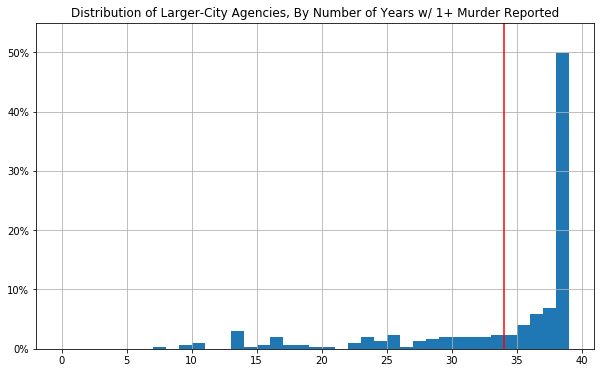

In [9]:
ax = (
    ori_year_counts
    .loc[lambda df: df["larger_city"] == True]    
    ["years"]
    .hist(
        figsize = (10, 6),
        bins = range(0, 40),
        density = True
    )
)
percentify_axes(ax)
ax.set_ylim(0, 0.55)
ax.axvline(34, color = "red")
ax.set_title("Distribution of Larger-City Agencies, By Number of Years w/ 1+ Murder Reported")
pass

In [10]:
consistent_oris = (
    ori_year_counts
    .loc[lambda df: df["years"] >= 34]
    ["agency_ori_7"]
)

# Note: Includes all agency types, not just larger-city agencies
len(consistent_oris)

594

Larger-city agencies account have, each year since 1980, accounted for the majority of murder victims reported via SHR:

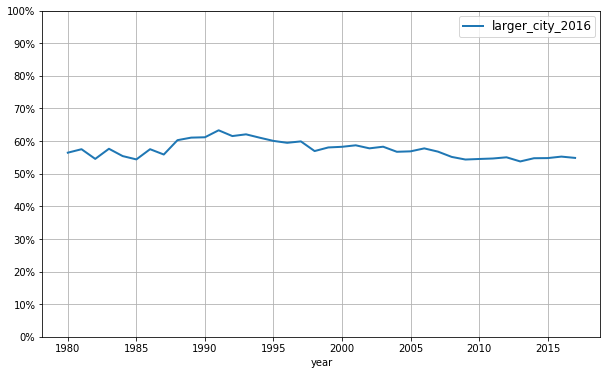

In [11]:
(
    murder_victims
    .groupby("year")
    ["larger_city_2016"].mean()
    .pipe(plot_rates)
)
pass

Among those murders reported by larger-city agencies, the vast majority were reported by consistently-reporting agencies:

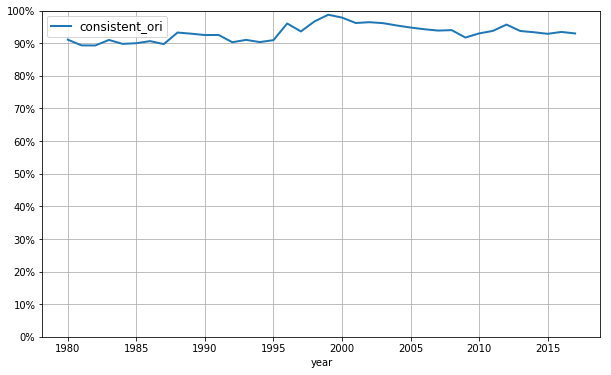

In [12]:
(
    murder_victims
    .assign(
        consistent_ori = lambda x: x["agency_ori_7"].isin(consistent_oris)
    )
    .loc[lambda df: df["larger_city_2016"] == True]
    .groupby("year")
    ["consistent_ori"].mean()
    .pipe(plot_rates)
)
pass

In [13]:
def get_larger_consistent(df):
    return (
        df
        .loc[lambda df: df["larger_city_2016"] == True]
        .loc[lambda df: df["agency_ori_7"].isin(consistent_oris)]
    )

# Examine distribution of offender age-reported, by agency-year

In [14]:
agency_year_ko_rates = (    
    murder_victims
    .groupby([ "agency_ori_7", "year", "larger_city_2016" ])
    .pipe(lambda x: pd.DataFrame({
        "incident_count_annual": x.size(),
        "offender_age_reported_annual": x["offender_age_reported"].mean()
    }))
    .reset_index()
)

agency_year_ko_rates.head()

,agency_ori_7,year,larger_city_2016,incident_count_annual,offender_age_reported_annual
0,AK00101,1980,True,17,0.705882
1,AK00101,1981,True,17,0.823529
2,AK00101,1982,True,22,0.454545
3,AK00101,1983,True,16,0.750000
4,AK00101,1984,True,16,0.875000


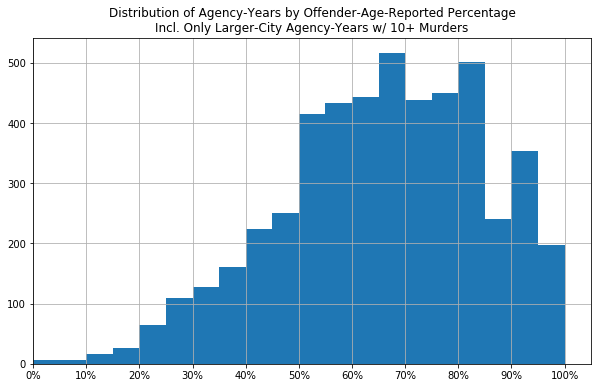

In [15]:
ax = (
    agency_year_ko_rates
    .loc[lambda df: df["larger_city_2016"] == True]
    .loc[lambda df: df["incident_count_annual"] >= 10]
    ["offender_age_reported_annual"]
    .clip(0, 0.9999)
    .hist(
        bins = pd.np.arange(0, 1.05, 0.05)
    )
)

ax.figure.set_size_inches((10, 6))

ax.set_title((
    "Distribution of Agency-Years by Offender-Age-Reported Percentage\n"
    "Incl. Only Larger-City Agency-Years w/ 10+ Murders"
))

percentify_axes(ax, name = "x", lim = (0, None))
pass

In [16]:
(   
    agency_year_ko_rates
    .loc[lambda df: df["larger_city_2016"] == True]
    .loc[lambda df: df["incident_count_annual"] >= 10]
    .loc[lambda df: df["offender_age_reported_annual"] < 0.1]
    .sort_values("offender_age_reported_annual")
)

,agency_ori_7,year,larger_city_2016,incident_count_annual,offender_age_reported_annual
2192,AL04701,1991,True,11,0.000000
17226,CA05604,2014,True,11,0.000000
44461,MI41436,2001,True,12,0.000000
20240,DCMPD00,1990,True,473,0.004228
20239,DCMPD00,1989,True,439,0.018223
20244,DCMPD00,1994,True,398,0.040201
9951,CA01933,2010,True,20,0.050000
649,AL00301,1991,True,36,0.055556
88889,TX01404,2017,True,15,0.066667
650,AL00301,1992,True,32,0.093750


In [17]:
(   
    agency_year_ko_rates
    .loc[lambda df: df["larger_city_2016"] == True]
    .loc[lambda df: df["agency_ori_7"] == "LANPD00"]
    .loc[lambda df: df["offender_age_reported_annual"] < 0.20]
    .sort_values("year")
)

,agency_ori_7,year,larger_city_2016,incident_count_annual,offender_age_reported_annual
39260,LANPD00,1998,True,231,0.190476
39262,LANPD00,2000,True,204,0.181373
39263,LANPD00,2001,True,211,0.199052
39264,LANPD00,2002,True,258,0.158915
39265,LANPD00,2003,True,274,0.142336
39266,LANPD00,2004,True,264,0.185606
39267,LANPD00,2005,True,133,0.187970
39270,LANPD00,2008,True,94,0.170213
39275,LANPD00,2013,True,135,0.192593


In [18]:
(   
    agency_year_ko_rates
    .loc[lambda df: df["larger_city_2016"] == True]
    .loc[lambda df: df["incident_count_annual"] >= 50]
    .loc[lambda df: df["offender_age_reported_annual"] >= 0.95]
    .sort_values("offender_age_reported_annual", ascending = False)
)

,agency_ori_7,year,larger_city_2016,incident_count_annual,offender_age_reported_annual
21474,FL02902,1992,True,53,1.000000
21476,FL02902,1994,True,64,1.000000
106960,WIMPD00,2008,True,71,0.971831
88297,TNMPD00,1984,True,103,0.970874
307,AL00102,1990,True,125,0.960000
37337,LA01702,1981,True,50,0.960000
64221,NM00101,2015,True,50,0.960000


In [19]:
(
    murder_victims
    .loc[lambda df: df["larger_city_2016"] == True]
    .merge(
        agency_year_ko_rates
        [[ "agency_ori_7", "year", "offender_age_reported_annual" ]],
        how = "left",
        on = [ "agency_ori_7", "year" ],
    )
    .assign(
        lt10_or_gt98 = lambda df: (
            (df["offender_age_reported_annual"] < 0.1) |
            (df["offender_age_reported_annual"] > 0.98)
        )
    )
    .groupby([
        "lt10_or_gt98"
    ])
    .size()
)

lt10_or_gt98
False    351919
True      11503
dtype: int64

# Victim demographics

### Create two new race/ethnicity variables

- `victim_race_h`: Here, Hispanic ethnicity takes precedence over race, an often used in the analysis of Census data.

- `victim_race_condensed`: Here, victim race and ethnicity are condensed further, into three categories: `Black/Hispanic`, `White`, and `Other` (which includes victims of other races, and victims for which race/ethnicity was listed as unknown).

In [20]:
murder_victims["victim_race"].value_counts()

W    307735
B    299697
A     10120
U      6991
I      4728
Name: victim_race, dtype: int64

In [21]:
(
    murder_victims
    .loc[lambda df: df["victim_ethnicity"] == "H"]
    ["victim_race"]
    .value_counts(normalize = True)
)

W    0.978222
B    0.017882
U    0.003063
A    0.000658
I    0.000175
Name: victim_race, dtype: float64

In [22]:
murder_victims["victim_race_h"] = (
    murder_victims
    ["victim_ethnicity"]
    .replace({ "U": None, "N": None })
    .astype(object)
    .fillna(murder_victims["victim_race"])
)
    
murder_victims["victim_race_h"].value_counts()

B    298366
W    234923
H     74433
A     10071
U      6763
I      4715
Name: victim_race_h, dtype: int64

In [23]:
murder_victims["victim_race_condensed"] = (
    murder_victims
    ["victim_race_h"]
    .apply({
        "B": "Black/Hispanic",
        "H": "Black/Hispanic",
        "W": "White",
    }.get)
    .fillna("Other")
)
    
murder_victims["victim_race_condensed"].value_counts()

Black/Hispanic    372799
White             234923
Other              21549
Name: victim_race_condensed, dtype: int64

In [24]:
(
    murder_victims
    .loc[lambda df: df["firearm_ind"] == True]
    .groupby([
        "year",
        "larger_city_2016",
    ])
    ["victim_race_condensed"]
    .value_counts(normalize = True)
    .unstack()
    ["Black/Hispanic"]
    .unstack()
    .loc[2015:]
)

larger_city_2016,False,True
year,,
2015,0.570723,0.834761
2016,0.579761,0.830132
2017,0.585898,0.822719


In [25]:
(
    murder_victims
    .loc[lambda df: df["firearm_ind"] == True]
    .loc[lambda df: df["larger_city_2016"] == True]
    .groupby([
        "year",
        "ori_group_2016",
    ])
    ["victim_race_condensed"]
    .value_counts(normalize = True)
    .unstack()
    ["Black/Hispanic"]
    .unstack()
    .loc[2015:]
)

ori_group_2016,1A,1B,1C,2
year,,,,
2015,0.864307,0.851064,0.847076,0.761557
2016,0.898058,0.824176,0.812094,0.755636
2017,0.908471,0.812353,0.791269,0.763302


In [26]:
(
    murder_victims
    .loc[lambda df: df["firearm_ind"] == True]
    .pipe(get_larger_consistent)    
    .groupby([
        "year",
    ])
    ["victim_race_condensed"]
    .value_counts(normalize = True)
    .unstack()
    ["Black/Hispanic"]
    .loc[2015:]
    .round(3)
    .to_frame("Black/Hispanic")    
)

,Black/Hispanic
year,
2015,0.837
2016,0.837
2017,0.830


## Examining missing ethnicity data

In [27]:
murder_victims["ethnic_origin_missing"] = murder_victims["victim_ethnicity"].isin([
    pd.np.nan,
    "U" # "U" stands for "Unknown or not reported"
])

murder_victims["ethnic_origin_missing"].mean()

0.560634448433187

In [28]:
(
    murder_victims
    .groupby("larger_city_2016")
    ["ethnic_origin_missing"]
    .mean()
)

larger_city_2016
False    0.572223
True     0.552157
Name: ethnic_origin_missing, dtype: float64

Overall:

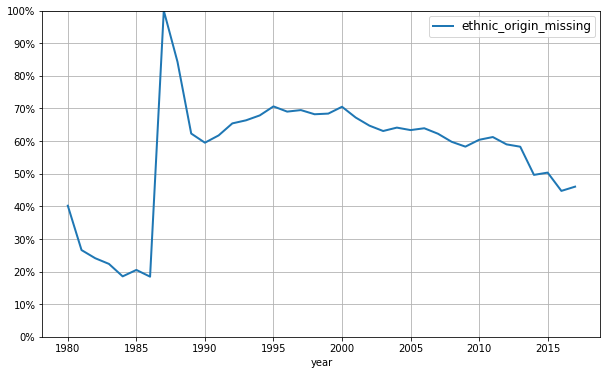

In [29]:
(    
    murder_victims
    .groupby(["year"])
    ["ethnic_origin_missing"]
    .mean()
    .pipe(plot_rates)
)
pass

Larger-city agencies:

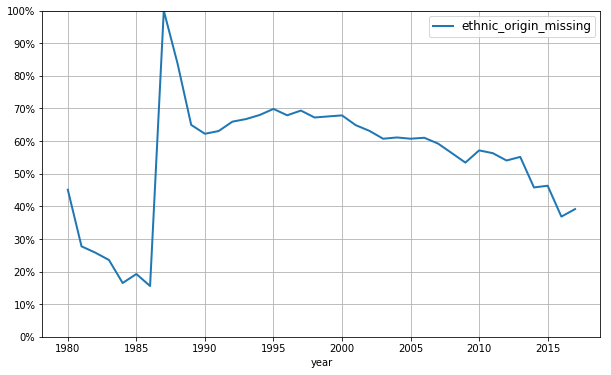

In [30]:
(    
    murder_victims
    .loc[lambda df: df["larger_city_2016"] == True]
    .groupby(["year"])
    ["ethnic_origin_missing"]
    .mean()
    .pipe(plot_rates)
)
pass

Race, for victims reported as Hispanic:

In [31]:
(
    murder_victims
    .loc[lambda df: df["larger_city_2016"] == True]    
    .loc[lambda df: df["victim_ethnicity"] == "H"]
    ["victim_race"]
    .value_counts(normalize = True)
)

W    0.977175
B    0.020227
U    0.001975
A    0.000561
I    0.000062
Name: victim_race, dtype: float64

By victim race:

In [32]:
(    
    murder_victims
    .loc[lambda df: df["year"] >= 1989]
    .groupby(["victim_race"])
    .pipe(lambda x: pd.DataFrame({
        "victim_count": x.size(),
        "missing_ethnicity_prop": x["ethnic_origin_missing"].mean()
    }))
    .reset_index()
    .sort_values("missing_ethnicity_prop", ascending = False)
)

,victim_race,victim_count,missing_ethnicity_prop
3,U,5433,0.953985
1,B,226034,0.707473
2,I,3488,0.602064
4,W,216516,0.533693
0,A,8122,0.459370


By agency-year:

In [33]:
missing_ethnicity_rates = (    
    murder_victims
    .loc[lambda df: df["larger_city_2016"] == True]
    .groupby(["agency_ori_7", "year"])
    .pipe(lambda x: pd.DataFrame({
        "victim_count": x.size(),
        "missing_ethnicity_prop": x["ethnic_origin_missing"].mean()
    }))
    .reset_index()
)

missing_ethnicity_rates.head()

,agency_ori_7,year,victim_count,missing_ethnicity_prop
0,AK00101,1980,17,1.000000
1,AK00101,1981,17,1.000000
2,AK00101,1982,22,0.863636
3,AK00101,1983,16,1.000000
4,AK00101,1984,16,1.000000


In [34]:
(
    missing_ethnicity_rates
    .loc[lambda df: df["missing_ethnicity_prop"] < 1]
    .groupby("agency_ori_7")
    .size()
    .value_counts(normalize = True)
    .sort_index(ascending = False)
    .cumsum()
    .to_frame("Cumulative Proportion")
    .head(10)
)

,Cumulative Proportion
37,0.118881
36,0.223776
35,0.255245
34,0.283217
33,0.293706
32,0.321678
31,0.339161
30,0.346154
28,0.356643
27,0.360140


Larger-city agencies with at least 10 years of the past 20 with no victim ethnicity information, and at least 1,000 murder victims during that time:

In [35]:
(
    missing_ethnicity_rates
    .loc[lambda df: df["missing_ethnicity_prop"] == 1]
    .loc[lambda df: df["year"] >= 1998]
    .loc[lambda df: df["year"] < 2018]
    .groupby("agency_ori_7")
    .pipe(lambda grp: pd.DataFrame({
        "years": grp.size(),
        "victims": grp["victim_count"].sum()
    }))
    .loc[lambda df: df["years"] >= 10]
    .loc[lambda df: df["victims"] >= 1000]
    .sort_values("victims", ascending = False)
)

,years,victims
agency_ori_7,,
ILCPD00,18,9319
MI82349,15,5219
MDBPD00,15,3794
LANPD00,16,3059
TNMPD00,20,2735
WIMPD00,19,2017
NV00201,16,1862
OHCOP00,20,1753
NJNPD00,20,1726


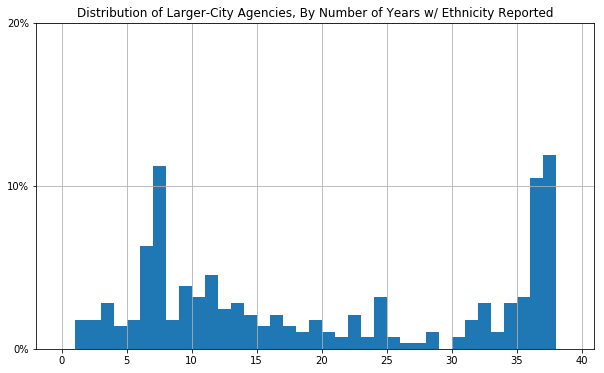

In [36]:
ax = (
    missing_ethnicity_rates
    .loc[lambda df: df["missing_ethnicity_prop"] < 1]
    .groupby("agency_ori_7")
    .size()
    .hist(
        bins = range(0, 40),
        density = True,
        
    )
)

percentify_axes(ax, (0, 0.20))
ax.figure.set_size_inches((10, 6))
ax.set_title("Distribution of Larger-City Agencies, By Number of Years w/ Ethnicity Reported")
pass

In [37]:
(    
    missing_ethnicity_rates
    .loc[lambda df: df["missing_ethnicity_prop"] < 1]
    .groupby("agency_ori_7")
    .size()
    .loc[lambda x: x >= 34]
    .reset_index()
    ["agency_ori_7"]
    .str.slice(0, 2)
    .value_counts()
)

CA    51
TX    21
AZ     6
NB     1
OR     1
NC     1
Name: agency_ori_7, dtype: int64

In [38]:
(
    murder_victims
    .pipe(get_larger_consistent)
    .loc[lambda df: df["year"] >= 2010]
    .assign(
        consistent_ethnicity = lambda df: df["agency_ori_7"].isin(
            missing_ethnicity_rates
            .loc[lambda df: df["missing_ethnicity_prop"] < 1]
            .groupby("agency_ori_7")
            .size()
            .loc[lambda x: x >= 34]
            .index
        )
    )
    .groupby([
        "consistent_ethnicity"
    ])
    ["victim_race"]
    .value_counts(normalize = True)
    .unstack()
    .T
)

consistent_ethnicity,False,True
victim_race,,
A,0.014432,0.034500
B,0.727564,0.386606
I,0.004421,0.004503
U,0.008436,0.015284
W,0.245147,0.559107


# Examine offender-age-reported rates over time

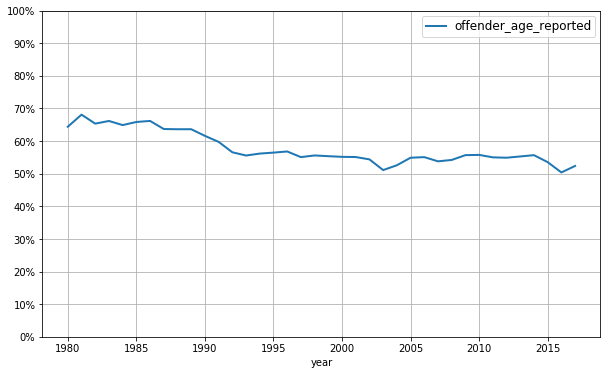

In [39]:
(
    murder_victims
    .pipe(get_larger_consistent)
    .groupby("year")
    ["offender_age_reported"]
    .mean()
    .pipe(
        plot_rates,
    )
);

In [40]:
def calc_reported_offender_by_victim_demog(df,
    group_var = "victim_race_condensed",
    x_axis = "year",
):
    return (
        df
        .groupby([ x_axis, group_var ])
        ["offender_age_reported"].mean()
        .unstack()
    )

In [41]:
def plot_reported_offender_by_victim_demog(
    df,
    group_var = "victim_race_condensed",
    groups = None,
    title = "",
    to_csv = None,
    **kwargs
):
    calcs = (
        df
        .pipe(
            calc_reported_offender_by_victim_demog,
            group_var
        )
        .pipe(lambda df: df if groups is None else df[groups])
    )
    
    if to_csv is not None:
        (
            calcs
            .round(3)
            .reset_index()
            .to_csv(
                to_csv,
                index = False
            )
        )
    
    ax = calcs.pipe(plot_rates, title = title, **kwargs)

    texts = []
    min_ind = min(calcs.index)
    max_ind = max(calcs.index)
    for year, row in calcs.loc[[min_ind, max_ind]].iterrows():
        for col in calcs.columns:
            nudge = -1 if year == min_ind else 1
            
            t = ax.text(
                year + nudge,
                row[col],
                "{:.0f}%".format(row[col] * 100)
            )
            
            texts.append(t)
        
    adjust_text(
        texts, 
        autoalign = 'y', 
        ax = ax,
        only_move = { 'points':'y', 'text':'y' },
        force_text = 0.1,
        force_points = 0,
        expand_text = (1, 1),
    )
    
    ax.set_ylabel("Offender Age Reported")
    ax.legend(title = group_var)
    return ax

In [42]:
(
    murder_victims
    .pipe(get_larger_consistent)
    ["agency_ori_7"]
    .nunique()
)

202

## By weapon

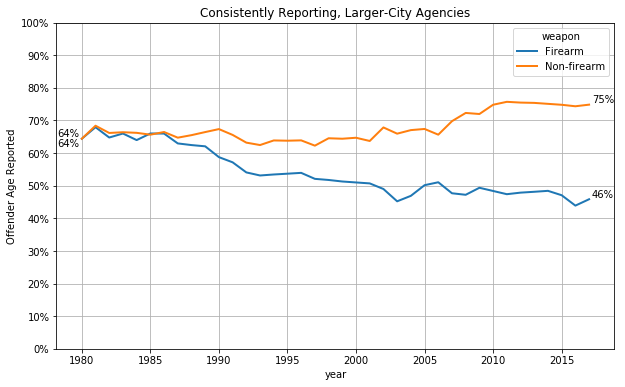

In [43]:
(
    murder_victims
    .pipe(get_larger_consistent)
    .assign(
        weapon = lambda df: pd.np.where(
            df["firearm_ind"] == 1,
            "Firearm",
            "Non-firearm"
        )
    )
    .pipe(
        plot_reported_offender_by_victim_demog,
        group_var = "weapon",
        title = "Consistently Reporting, Larger-City Agencies",
        to_csv = "../../outputs/shr-offender-reported-by-weapon.csv",
    )
);

Running the calculations on a per-incident, rather than per-victim level, makes little difference:

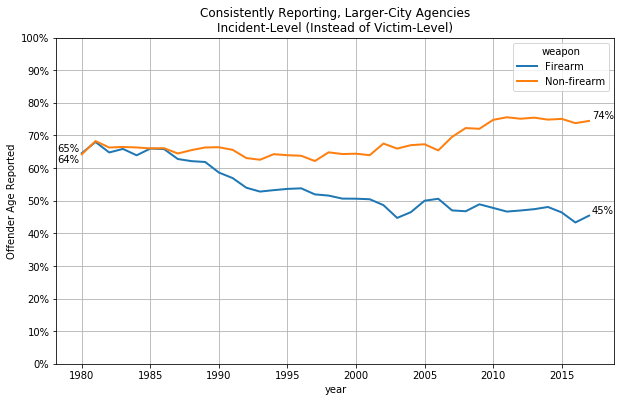

In [44]:
(
    murder_victims
    .pipe(get_larger_consistent)
    .drop_duplicates(subset = [
        "incident_uid",
        "firearm_ind",
        "offender_age_reported",
    ])
    .assign(
        weapon = lambda df: pd.np.where(
            df["firearm_ind"] == 1,
            "Firearm",
            "Non-firearm"
        )
    )
    .pipe(
        plot_reported_offender_by_victim_demog,
        group_var = "weapon",
        title = (
            "Consistently Reporting, Larger-City Agencies\n"
            "Incident-Level (Instead of Victim-Level)"
        ),
    )
);

# By victim race/ethnicity

### Examine racial composition of victims over time

Overall:

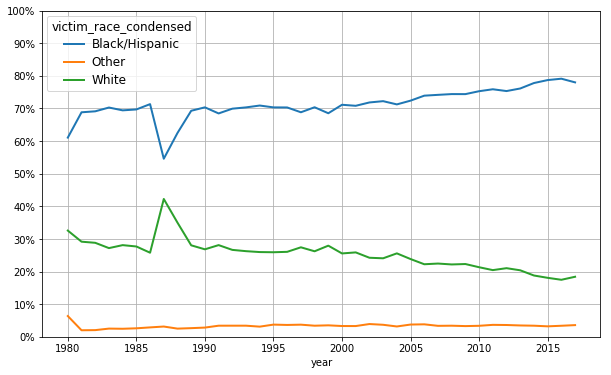

In [45]:
(
    murder_victims
    .pipe(get_larger_consistent)
    .groupby([ "year" ])
    ["victim_race_condensed"]
    .value_counts(normalize = True)
    .unstack()
    .pipe(plot_rates)
)
pass

For firearm murders:

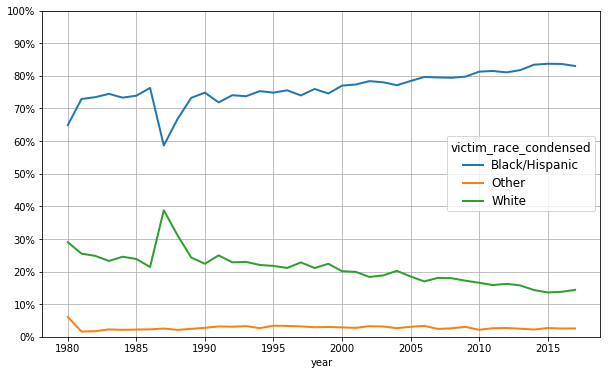

In [46]:
(
    murder_victims
    .pipe(get_larger_consistent)
    .loc[lambda df: df["firearm_ind"] == True]
    .groupby([ "year" ])
    ["victim_race_condensed"]
    .value_counts(normalize = True)
    .unstack()
    .pipe(plot_rates)
)
pass

### Examine offender-age-reported rates

For 2017, only among larger-city agencies (regardless of historical reporting consistency) that reported at least one victim's ethnicity:

In [47]:
(
    murder_victims
    .loc[lambda df: df["agency_ori_7"].isin(
        missing_ethnicity_rates
        .loc[lambda df: df["year"] == 2017]
        .loc[lambda df: df["missing_ethnicity_prop"] < 1]
        ["agency_ori_7"]
    )]
    .loc[lambda df: df["year"] == 2017]
    .loc[lambda df: df["victim_race_h"].isin([ "B", "H", "W" ])]
    .loc[lambda df: df["larger_city_2016"] == True]
    .groupby([ "firearm_ind", "victim_race_h" ])
    ["offender_age_reported"]
    .mean()
    .unstack()
)

victim_race_h,B,H,W
firearm_ind,,,
0,0.716632,0.722857,0.791667
1,0.345960,0.422773,0.581858


Overall:

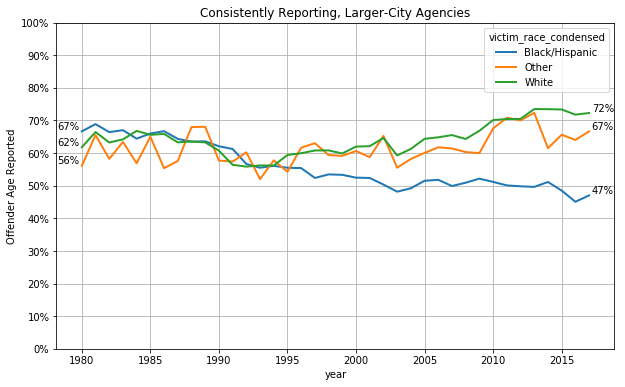

In [48]:
(
    murder_victims
    .pipe(get_larger_consistent)
    .pipe(
        plot_reported_offender_by_victim_demog,
        group_var = "victim_race_condensed",
        title = "Consistently Reporting, Larger-City Agencies",
        to_csv = "../../outputs/shr-offender-reported-by-race-all-weapons.csv",
    )
);

Non-firearm murders:

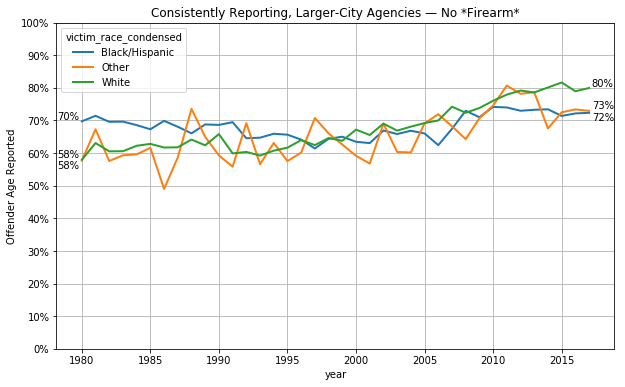

In [49]:
(
    murder_victims
    .loc[lambda df: df["firearm_ind"] == False]
    .pipe(get_larger_consistent)
    .pipe(
        plot_reported_offender_by_victim_demog,
        group_var = "victim_race_condensed",
        title = "Consistently Reporting, Larger-City Agencies — No *Firearm*",
        to_csv = "../../outputs/shr-offender-reported-by-race-no-firearm.csv",
    )
);

Firearm murders:

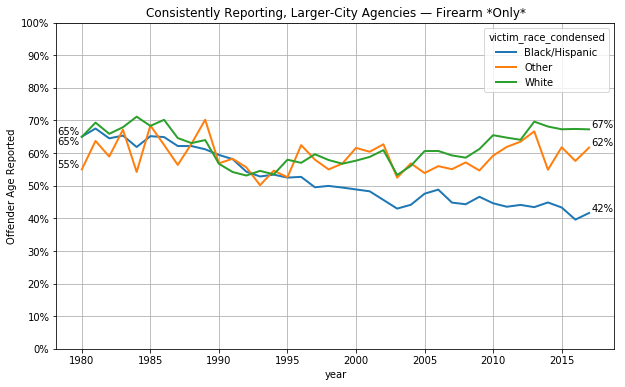

In [50]:
(
    murder_victims
    .loc[lambda df: df["firearm_ind"] == True]
    .pipe(get_larger_consistent)
    .pipe(
        plot_reported_offender_by_victim_demog,
        group_var = "victim_race_condensed",
        title = "Consistently Reporting, Larger-City Agencies — Firearm *Only*",
        to_csv = "../../outputs/shr-offender-reported-by-race-firearm-only.csv",
    )
);

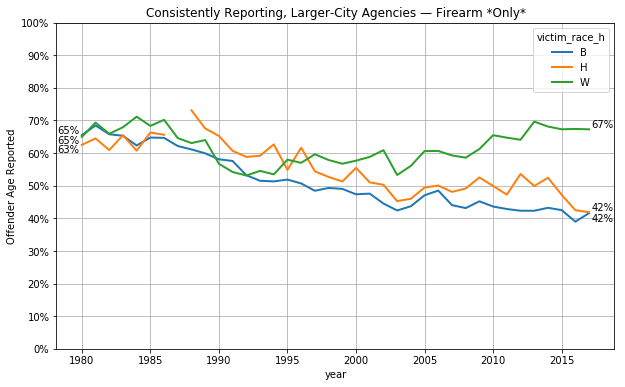

In [51]:
(
    murder_victims
    .loc[lambda df: df["firearm_ind"] == True]
    .pipe(get_larger_consistent)
    .pipe(
        plot_reported_offender_by_victim_demog,
        group_var = "victim_race_h",
        groups = [ "B", "H", "W", ],
        title = "Consistently Reporting, Larger-City Agencies — Firearm *Only*",
    )
);

## By weapon and race/ethnicity

In [52]:
def plot_quadlines(df, **kwargs):
    ax = (
        df
        .loc[lambda df: df["victim_race_condensed"].isin([
            "Black/Hispanic",
            "White"
        ])]
        .assign(
            a = lambda df: pd.np.where(
                df["firearm_ind"] == 1,
                "Firearm",
                "non-Firearm"
            ),
        )
        .assign(
            metagroup = lambda df: df["a"] + " - " + df["victim_race_condensed"]
        )
        .pipe(
            plot_reported_offender_by_victim_demog,
            group_var = "metagroup",
            **kwargs
        )
    )
    percentify_axes(ax)
    pal = sns.color_palette()
    for line in ax.get_lines():
        line.set_color(pal[0] if "Black" in line._label else pal[1])
        line.set_linestyle(":" if "non-Firearm" in line._label else "-")
    ax.legend()

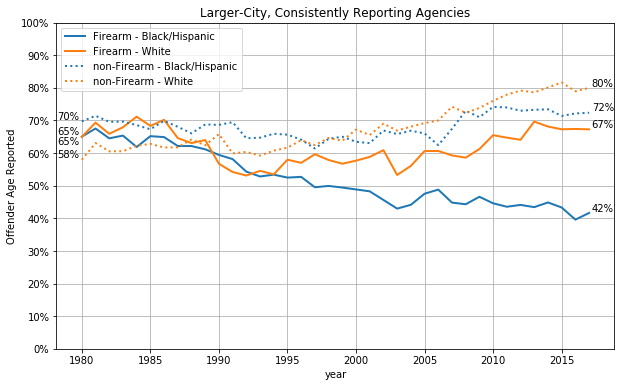

In [53]:
(
    murder_victims
    .pipe(get_larger_consistent)
    .pipe(
        plot_quadlines,
        title = "Larger-City, Consistently Reporting Agencies",
        to_csv = "../../outputs/shr-offender-reported-by-weapon-and-race.csv",
    )
)

For 2013-16, together, regardless of reporting consistency:

In [54]:
(
    murder_victims
    .loc[lambda df: df["larger_city_2016"] == True]
    .loc[lambda df: df["year"] >= 2013]
    .loc[lambda df: df["year"] <= 2016]
    .groupby([
        "firearm_ind",
        "victim_race_condensed",
    ])
    ["offender_age_reported"]
    .mean()
    .unstack()
    .assign(diff = lambda df: df["White"] - df["Black/Hispanic"])
    .round(3)
)

victim_race_condensed,Black/Hispanic,Other,White,diff
firearm_ind,,,,
0,0.728,0.740,0.807,0.078
1,0.429,0.613,0.696,0.267


Condensing victim groups even further:

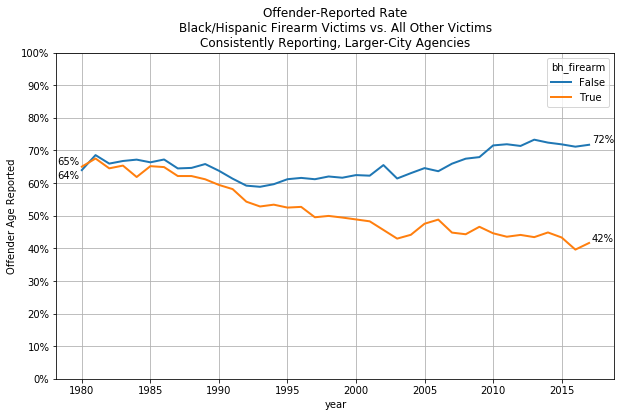

In [55]:
(
    murder_victims
    .pipe(get_larger_consistent)
    .assign(bh_firearm = lambda df: (
        df["victim_race_condensed"].isin([
            "Black/Hispanic",
        ]) &
        (df["firearm_ind"] == 1)
    ))
    .pipe(
        plot_reported_offender_by_victim_demog,
        group_var = "bh_firearm",
        title = (
            "Offender-Reported Rate\n"
            "Black/Hispanic Firearm Victims vs. All Other Victims\n"
            "Consistently Reporting, Larger-City Agencies"
        )
    )
)
pass

Even after removing incidents where the offenders are suspected to have been a family member or intimate partner, the disparity persists:

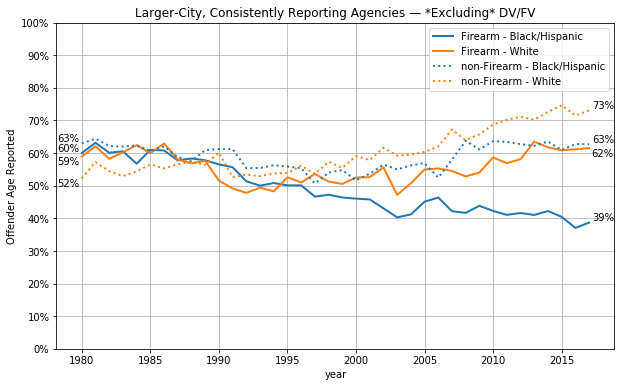

In [56]:
(
    murder_victims
    .loc[lambda df: df["domestic_violence_ind"] == 0]
    .loc[lambda df: df["family_violence_ind"] == 0]    
    .pipe(get_larger_consistent)
    .pipe(
        plot_quadlines,
        title = "Larger-City, Consistently Reporting Agencies — *Excluding* DV/FV",
    )
)

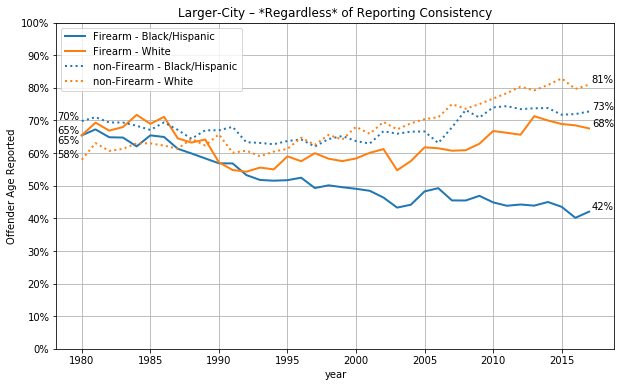

In [57]:
(
    murder_victims
    .loc[lambda df: df["larger_city_2016"] == 1]
    .pipe(
        plot_quadlines,
        title = "Larger-City – *Regardless* of Reporting Consistency",
    )
)

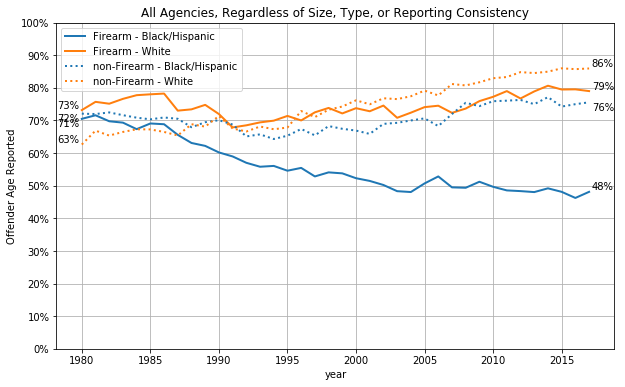

In [58]:
(
    murder_victims
    .pipe(
        plot_quadlines,
        title = "All Agencies, Regardless of Size, Type, or Reporting Consistency",
    )
)

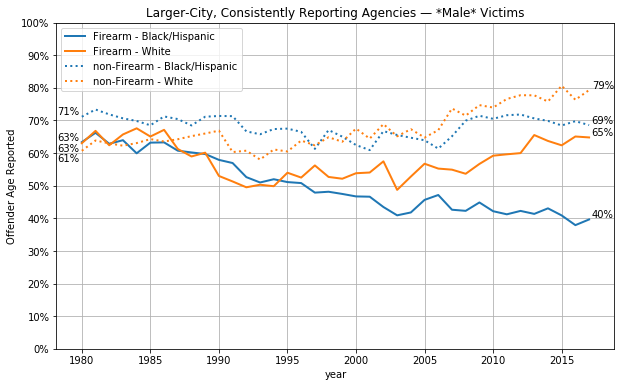

In [59]:
(
    murder_victims
    .loc[lambda df: df["victim_sex"] == "M"]
    .pipe(get_larger_consistent)    
    .pipe(
        plot_quadlines,
        title = "Larger-City, Consistently Reporting Agencies — *Male* Victims",
    )
)

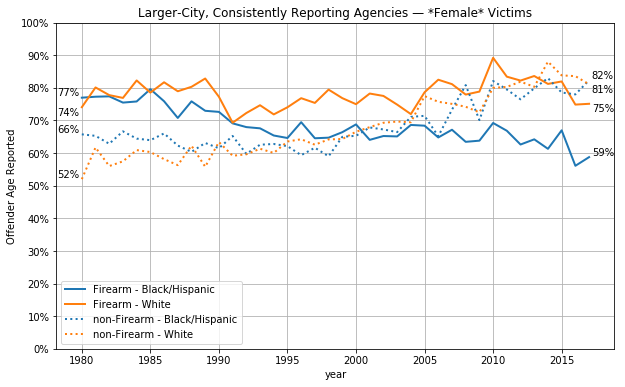

In [60]:
(
    murder_victims
    .loc[lambda df: df["victim_sex"] == "F"]
    .pipe(get_larger_consistent)    
    .pipe(
        plot_quadlines,
        title = "Larger-City, Consistently Reporting Agencies — *Female* Victims",
    )
)

### Excluding persistently-low offender-age-reported agencies

Some agencies have reported very few offender ages for some years. In this step, we run an alternative analysis that removes agencies that post persistently low offender-age-reported rates (here, for fewer than 20% of victims), and see that this approach does not change the overall results by much.

In [61]:
ori_year_counts_oar_gte_20 = (
    murder_victims
    .groupby([
        "agency_ori_7",
        "year"
    ])
    ["offender_age_reported"]
    .mean()
    .loc[lambda df: df >= 0.2]
    .reset_index()
    .groupby("agency_ori_7")
    ["year"]
    .nunique()
    .to_frame("years")
    .reset_index()
    .merge(
        agency_metadata_2016,
        how = "left",
        on = "agency_ori_7"
    )

)
ori_year_counts_oar_gte_20.head()

,agency_ori_7,years,year,ori_group,pop1,larger_city
0,AK00101,38,2016.0,1C,299097.0,True
1,AK00102,31,2016.0,4,32456.0,False
2,AK00103,11,2015.0,4,32482.0,False
3,AK00104,12,2015.0,6,8286.0,False
4,AK00105,3,2016.0,6,6274.0,False


63% of larger-city agencies have reported a murder *and* an offender-age-reported rate of 20%+ in at least 34 of the 38 years:

In [62]:
(
    ori_year_counts_oar_gte_20
    .loc[lambda df: df["larger_city"] == True]
    .groupby("years")
    .size()
    .sort_index(ascending = False)
    .to_frame("agency_count")
    .assign(agency_cumul = lambda x: x["agency_count"].cumsum())
    .assign(agency_cumul_pct = lambda x: (x["agency_cumul"] * 100 / x["agency_count"].sum()).round(1))
    .head(10)
)

,agency_count,agency_cumul,agency_cumul_pct
years,,,
38,109,109,37.2
37,27,136,46.4
36,25,161,54.9
35,15,176,60.1
34,9,185,63.1
33,4,189,64.5
32,8,197,67.2
31,9,206,70.3
30,8,214,73.0


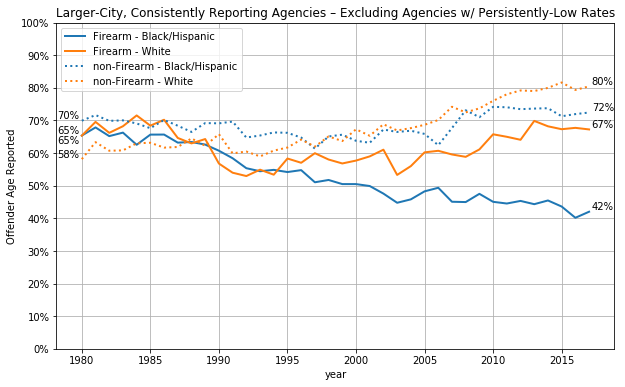

In [63]:
(
    murder_victims
    .loc[lambda df: df["agency_ori_7"].isin(
        ori_year_counts_oar_gte_20
        .loc[lambda df: df["years"] >= 34]
        ["agency_ori_7"]
    )]
    .pipe(get_larger_consistent)
    .pipe(
        plot_quadlines,
        title = "Larger-City, Consistently Reporting Agencies – Excluding Agencies w/ Persistently-Low Rates",
    )
)

# Firearm rates, by victim race/ethnicity

Among all larger-city agencies:

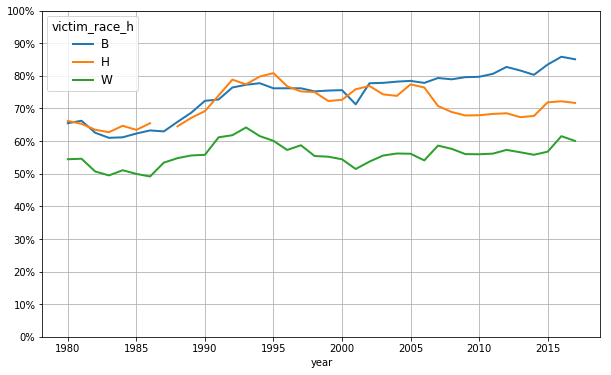

In [64]:
(
    murder_victims
    .loc[lambda df: df["larger_city_2016"] == True]
    .groupby([ "year", "victim_race_h" ])
    ["firearm_ind"]
    .mean()
    .unstack()
    [[ "B", "H", "W" ]]
    .pipe(plot_rates)
)
pass

Among consistently-reporting larger-city agencies:

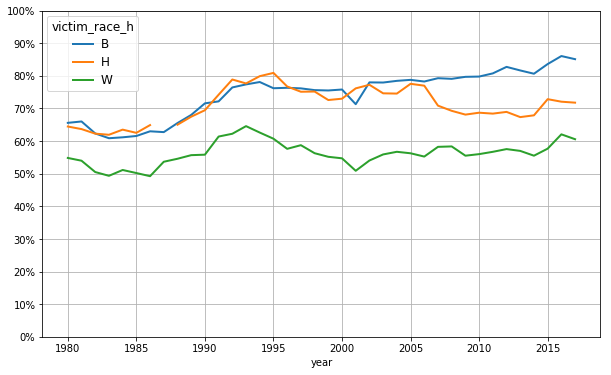

In [65]:
(
    murder_victims
    .pipe(get_larger_consistent)
    .groupby([ "year", "victim_race_h" ])
    ["firearm_ind"]
    .mean()
    .unstack()
    [[ "B", "H", "W" ]]
    .pipe(plot_rates)
)
pass

# Examining offense circumstances

Circumstances, ranked by frequency:

In [66]:
(
    murder_victims
    ["circumstance_main"]
    .value_counts(normalize = True)
)

Circumstances undetermined              0.292805
Other arguments                         0.279071
Other                                   0.131158
Robbery                                 0.082732
Narcotic drug laws                      0.042255
Juvenile gang killings                  0.037323
Other - not specified                   0.023165
Argument over money or property         0.019726
Brawl due to influence of alcohol       0.018784
Lovers triangle                         0.014201
All suspected felony type               0.014132
Burglary                                0.008902
Brawl due to influence of narcotics     0.007580
Gangland killings                       0.007148
Arson                                   0.006123
Rape                                    0.005335
Motor vehicle theft                     0.001934
Child killed by babysitter              0.001824
Other sex offense                       0.001800
Gambling                                0.001227
Larceny             

Among firearm incidents:

In [67]:
circumstance_proportions = (
    murder_victims
    .loc[lambda df: df["firearm_ind"] == True]    
    ["circumstance_main"]
    .value_counts(normalize = True)
    .to_frame("proportion")
)

circumstance_proportions

,proportion
Circumstances undetermined,0.304242
Other arguments,0.267528
Other,0.113915
Robbery,0.087820
Narcotic drug laws,0.054254
Juvenile gang killings,0.052956
Other - not specified,0.021627
Argument over money or property,0.020280
Brawl due to influence of alcohol,0.016378
Lovers triangle,0.015385


In [68]:
circumstance_disparities = (
    murder_victims
    .loc[lambda df: df["year"] >= 2008]
    .loc[lambda df: df["firearm_ind"] == True]
    .pipe(get_larger_consistent)
    .pipe(
        calc_reported_offender_by_victim_demog,
        x_axis = "circumstance_main"
    )
    .assign(
        bw_diff = lambda df: df["Black/Hispanic"] - df["White"]
    )
    .join(circumstance_proportions)
    .sort_values("proportion", ascending = False)
    .loc[lambda df: df["proportion"] >= 0.005]
    .pipe(save, "../../outputs/shr-circumstance-rates.csv", index = True)
)

circumstance_disparities

,Black/Hispanic,Other,White,bw_diff,proportion
circumstance_main,,,,,
Circumstances undetermined,0.281263,0.422998,0.486951,-0.205688,0.304242
Other arguments,0.755498,0.862205,0.896658,-0.141161,0.267528
Other,0.528900,0.733333,0.808940,-0.280039,0.113915
Robbery,0.538494,0.619289,0.649077,-0.110583,0.087820
Narcotic drug laws,0.463880,0.750000,0.623853,-0.159973,0.054254
Juvenile gang killings,0.338632,0.434211,0.337638,0.000993,0.052956
Other - not specified,0.456874,0.464286,0.736641,-0.279767,0.021627
Argument over money or property,0.781818,0.952381,0.893204,-0.111386,0.020280
Brawl due to influence of alcohol,0.670213,0.888889,0.937500,-0.267287,0.016378


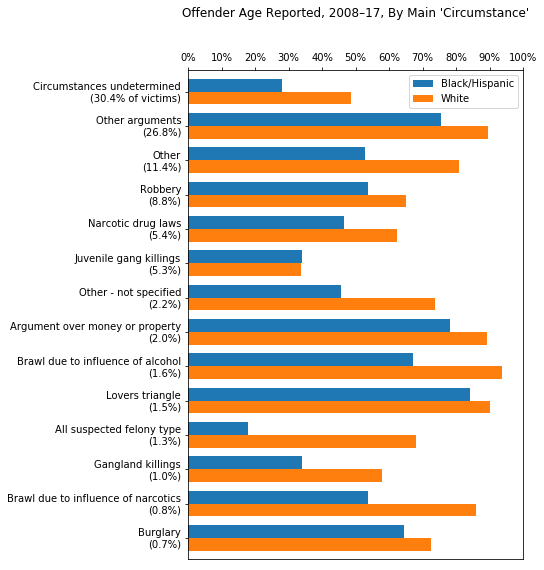

In [69]:
ax = (
    circumstance_disparities
    [[ "Black/Hispanic", "White" ]]
    .plot.barh(
        figsize = (6, 9),
        width = 0.75,
        title = "Offender Age Reported, 2008–17, By Main 'Circumstance'\n\n"
    )
)
plt.gca().invert_yaxis()
ax.xaxis.tick_top()
ax.set_ylabel("")
percentify_axes(ax, name = "x")
ax.set_yticklabels([ (
    f"{df['circumstance_main']}\n"
    f"({df['proportion'] * 100:0.1f}%{' of victims' if i == 0 else ''})"
) for i, df in circumstance_disparities.reset_index().iterrows()  ])
pass

In [70]:
def plot_circumstance_oar(circs):
    (
        murder_victims
        .loc[lambda df: df["firearm_ind"] == True]
        .loc[lambda df: df["circumstance_main"].isin(circs)]
        .pipe(get_larger_consistent)
        .pipe(
            plot_reported_offender_by_victim_demog,
            "victim_race_condensed",
            groups = [ "Black/Hispanic", "White" ],
            title = "\n".join(circs)
        )
    )

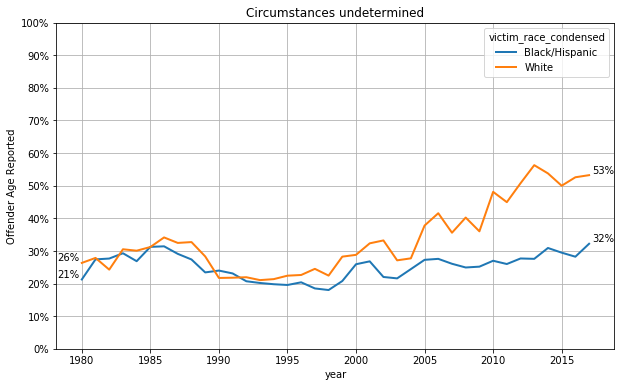

In [71]:
plot_circumstance_oar([
    "Circumstances undetermined",
])

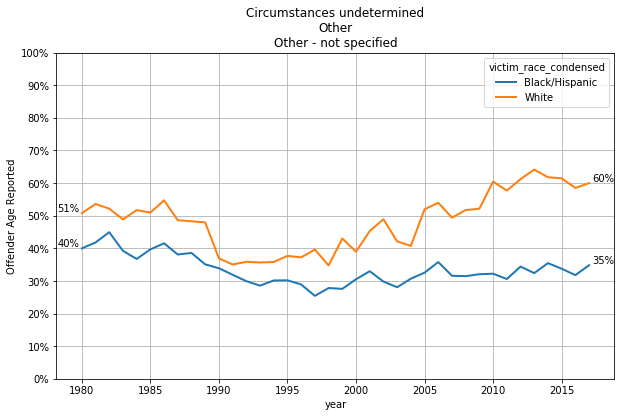

In [72]:
plot_circumstance_oar([
    "Circumstances undetermined",
    "Other",
    "Other - not specified"
])

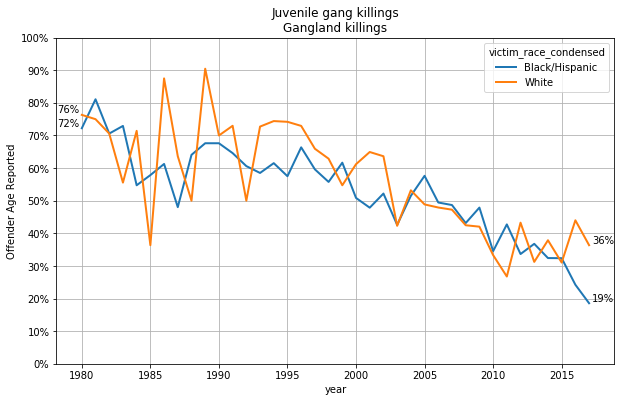

In [73]:
plot_circumstance_oar([
    "Juvenile gang killings",
    "Gangland killings"
])

In [74]:
def plot_circumstance_prop(circs):
    ax = (
        murder_victims
        .loc[lambda df: df["firearm_ind"] == True]
        .pipe(get_larger_consistent)
        .loc[lambda df: df["victim_race_condensed"].isin([
            "Black/Hispanic",
            "White" 
        ])]
        .assign(
            is_circ = lambda df: df["circumstance_main"].isin(circs)
        )
        .groupby([ "year", "victim_race_condensed" ])
        ["is_circ"].mean()
        .unstack()
        .pipe(
            plot_rates,
            title = "Proportion of victims with circumstance:\n" + "\n".join(f"'{c}'" for c in circs))
    )
    ax.set_ylabel("Proportion of Victims")
    pass

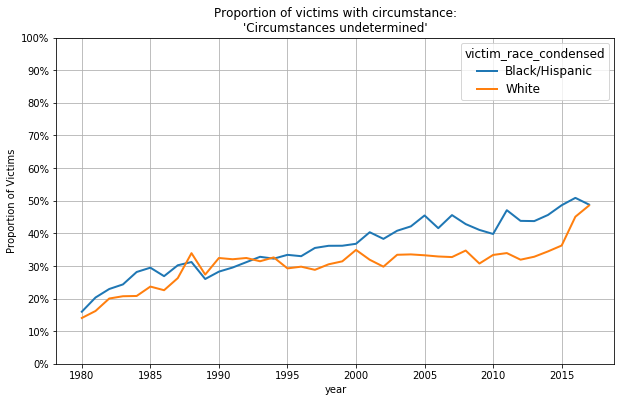

In [75]:
plot_circumstance_prop([
    "Circumstances undetermined",
])

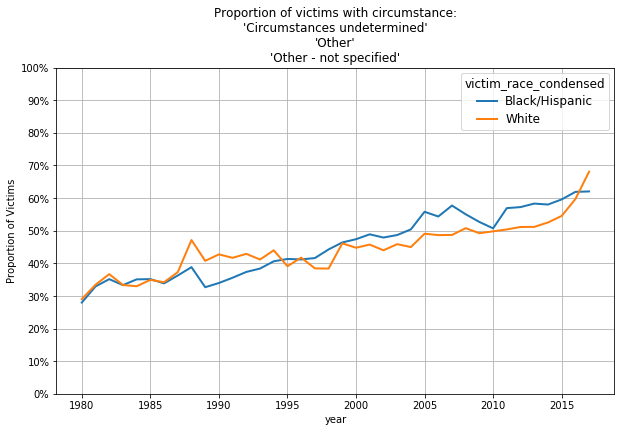

In [76]:
plot_circumstance_prop([
    "Circumstances undetermined",
    "Other",
    "Other - not specified"
])

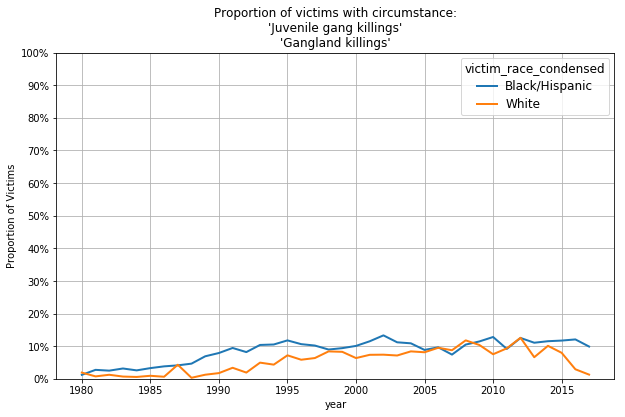

In [77]:
plot_circumstance_prop([
    "Juvenile gang killings",
    "Gangland killings"
])

# Victim Demographics vs. Overall Agency Offender-Reported Rates

In [78]:
def calc_agency_metrics_condensed(victims):
    return (
        victims
        .groupby([
            "agency_ori_7",
        ])
        .pipe(lambda ori_grp: (
            ori_grp
            .apply(lambda df: (
                df
                .groupby([
                    "victim_race_condensed"
                ])
                .pipe(lambda grp: pd.DataFrame({
                    "offender_age_reported": grp["offender_age_reported"].mean(),
                    "count": grp.size()
                }))
            ))
            .unstack()
            .pipe(lambda df: pd.DataFrame({
                "oar_black": df["offender_age_reported"]["Black/Hispanic"],
                "oar_white": df["offender_age_reported"]["White"],
                "victims_total": df["count"].sum(axis = 1),
                "victims_black": df["count"]["Black/Hispanic"],
                "victims_white": df["count"]["White"],
            }))
            .assign(
                oar_bw_diff = lambda df: df["oar_black"] - df["oar_white"],
                victims_bw_ratio = lambda df: df["victims_black"] / df["victims_white"],
            )
            .assign(
                victims_bw_ratio_log = lambda df: pd.np.log10(df["victims_bw_ratio"])
            )
            .join(
                ori_grp
                ["offender_age_reported"]
                .mean()
                .to_frame("oar_overall")
            )
        ))
    )

In [79]:
def translate_bw_log(x):
    if x == 0:
        return "1-to-1"
    elif x < 0:
        return f"{1 / pow(10, x):.0f}x Wh."
    else:
        return f"{pow(10, x):.0f}x B/H"

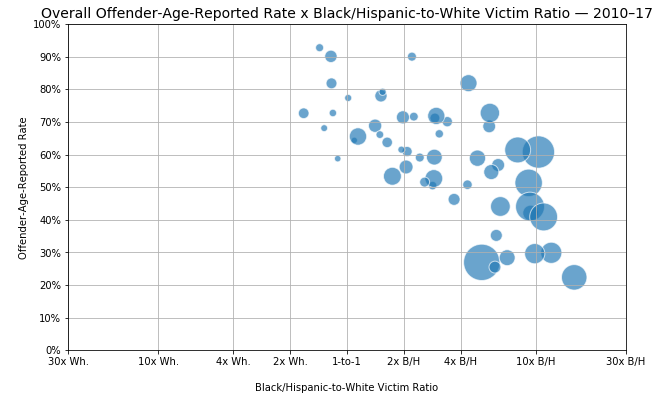

In [80]:
fig, ax = plt.subplots(
    figsize = (10, 6),
    facecolor = "white"
)

(
    murder_victims
    .loc[lambda df: df["larger_city_2016"] == True]
    .loc[lambda df: df["year"] >= 2010]
    .loc[lambda df: df["year"] <= 2017]
    .pipe(calc_agency_metrics_condensed)
    .loc[lambda df: df["victims_white"] >= 50]
    .loc[lambda df: df["victims_black"] >= 50]

    .pipe(lambda df:
        plt.scatter(
            df["victims_bw_ratio_log"],
            df["oar_overall"],     
            s = df["victims_total"] / 3,
            edgecolor = "white",
            alpha = 2/3,
        )
    )
)

    
    
ax.set_title("Overall Offender-Age-Reported Rate x Black/Hispanic-to-White Victim Ratio — 2010–17", fontsize = 14)
ax.set_xlim(-1.3, 1.3)
ax.set_xlabel("\nBlack/Hispanic-to-White Victim Ratio")
ax.set_ylabel("\nOffender-Age-Reported Rate")
percentify_axes(ax)
ax.set_xticks([ pd.np.log10(x) for x in [ 1 / 30, 1/10, 1/4, 1/2, 1, 2, 4, 10, 30 ]])
ax.set_xticklabels(list(map(translate_bw_log, ax.get_xticks())))
ax.grid()
pass

# Distribution of offender-reported rates, firearm only, by race, agency, and decade

In [81]:
agency_decade_disparities = (
    murder_victims
    .pipe(get_larger_consistent)
    .loc[lambda df: df["victim_race_condensed"].isin([
        "Black/Hispanic",
        "White"
    ])]
    .assign(decade = lambda df: 10 * (df["year"] // 10))
    .groupby([
        "firearm_ind",
        "agency_ori_7",
        "decade",
        "victim_race_condensed",
    ])
    .pipe(lambda df: pd.DataFrame({
        "num_victims": df.size(),
        "offender_age_reported": df["offender_age_reported"].mean()
    }))
    # Remove groupings of less than 10 victims
    .loc[lambda df: df["num_victims"] >= 10]
    .dropna()
    
    # Reshape so that each row is an agency-decade combination
    # and each column is an offender-reported rate
    ["offender_age_reported"]
    .unstack()
    
    # Remove agency-decades with fewer than 10 white victims
    # or less than 10 black/Hispanic victims each of the four decades
    .unstack()
    .dropna()
    .stack()
    .reset_index()
    .rename_axis(None, axis = 1)
    .assign(
        diff = lambda df: (df["White"] - df["Black/Hispanic"]).round(3)
    )
    .pipe(save, "../../outputs/shr-agency-disparities-by-decade-and-firearm.csv")
)

agency_decade_disparities.head()

,firearm_ind,agency_ori_7,decade,Black/Hispanic,White,diff
0,0,AR06002,1980,0.865672,0.793103,-0.073
1,0,AR06002,1990,0.793651,0.586207,-0.207
2,0,AR06002,2000,0.684211,0.785714,0.102
3,0,AR06002,2010,0.909091,0.807692,-0.101
4,0,AZ00723,1980,0.560000,0.557377,-0.003


In [82]:
(
    agency_decade_disparities
    .groupby("firearm_ind")
    ["agency_ori_7"]
    .nunique()
)

firearm_ind
0     81
1    105
Name: agency_ori_7, dtype: int64

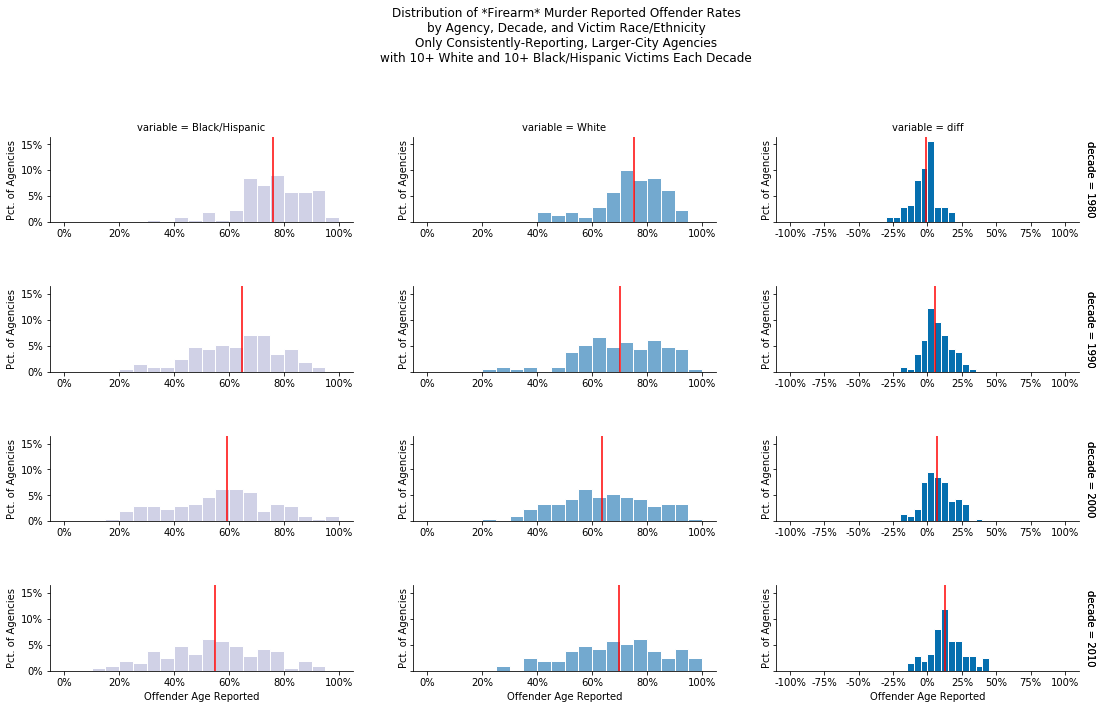

In [83]:
(
    agency_decade_disparities
    .loc[lambda df: df["firearm_ind"] == 1]
    .drop(columns = [ "firearm_ind" ])
    .melt(
        id_vars = [ "agency_ori_7", "decade" ],
        value_name = "Offender Age Reported"
    )
    .pipe(
        make_histogram_grid,
        title = (
            "Distribution of *Firearm* Murder Reported Offender Rates\n"
            "by Agency, Decade, and Victim Race/Ethnicity\n"
            "Only Consistently-Reporting, Larger-City Agencies\n"
            "with 10+ White and 10+ Black/Hispanic Victims Each Decade"
        ),
        value = "Offender Age Reported",
        row = "decade",
        col = "variable",
        hue = "variable",
    )
)
pass

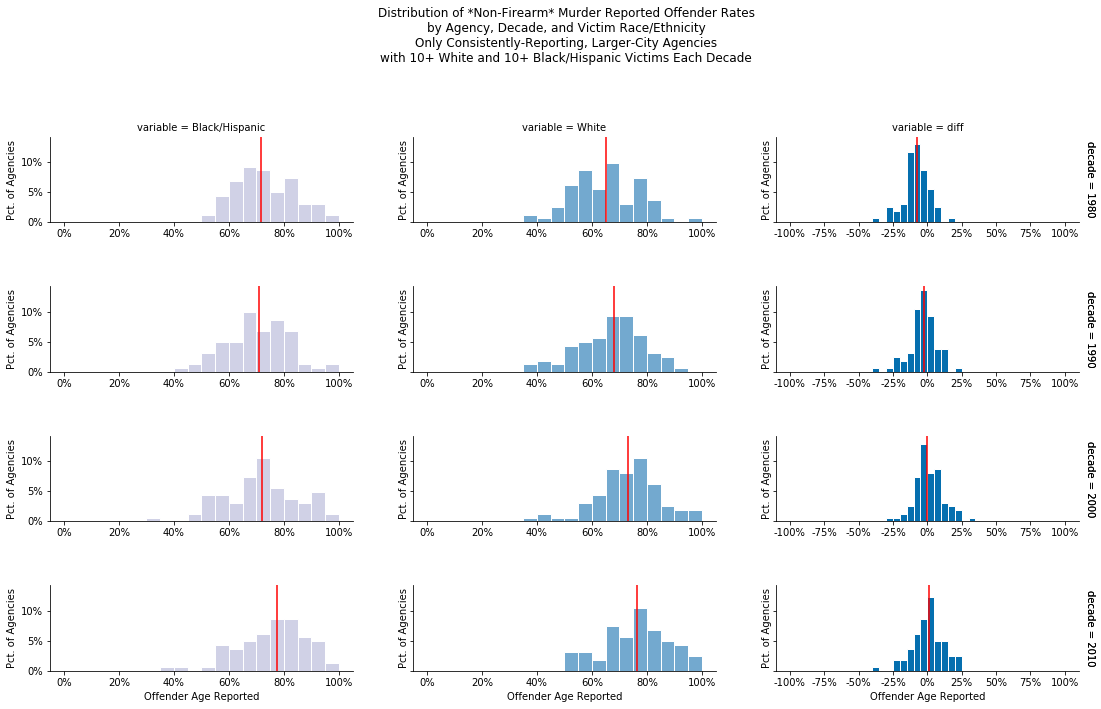

In [84]:
(
    agency_decade_disparities
    .loc[lambda df: df["firearm_ind"] == 0]
    .drop(columns = [ "firearm_ind" ])
    .melt(
        id_vars = [ "agency_ori_7", "decade" ],
        value_name = "Offender Age Reported"
    )
    .pipe(
        make_histogram_grid,
        title = (
            "Distribution of *Non-Firearm* Murder Reported Offender Rates\n"
            "by Agency, Decade, and Victim Race/Ethnicity\n"
            "Only Consistently-Reporting, Larger-City Agencies\n"
            "with 10+ White and 10+ Black/Hispanic Victims Each Decade"
        ),
        value = "Offender Age Reported",
        row = "decade",
        col = "variable",
        hue = "variable",
    )
)
pass

---

---

---